In [1]:
import os
import sys
import collections
import random
import gc
import bisect
from math import sqrt

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl

import sklearn.svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from keras.models import Sequential
from keras.layers import LSTM,Flatten,Dense,Embedding,GRU,BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD


%matplotlib inline


#  ElapsedTime: Time from start event to completion event for a specific IO in microseconds
#  Timestamp: Time from start of trace in microseconds
# file is about data collected in 10 minutes
# we can divide timescale into bins of millisecond range

Using TensorFlow backend.


In [2]:
os.listdir()

['.ipynb_checkpoints',
 'Microsoft',
 'MSNStorageCFS_sortedFrame.csv',
 'MSNStorageFileServer_sortedFrame.csv',
 'restart.ipynb']

In [3]:
def loader(fname):
    data = pd.read_csv(fname,usecols = ['TimeStamp',
                                        'Disk Operation',
                                        'Process Name ( PID)'],
                      index_col = False,
                      engine = 'python')
    return data
    

In [4]:
cfs = loader( 'MSNStorageCFS_sortedFrame.csv')
cfs.head()

,Disk Operation,TimeStamp,Process Name ( PID)
0,DiskRead,209710,p0
1,DiskRead,224548,p1
2,DiskRead,224909,p1
3,DiskRead,226255,p2
4,DiskRead,226834,p2


In [7]:
def convert(df):
    ops = df.loc[:,'Disk Operation'].unique()
    ops_dict = {ops[i]: 0 if 'Read' in ops[i] else 1 for i in range(len(ops))}
    pids = df.loc[:,'Process Name ( PID)'].unique()
    pids_dict = {pids[i]: i for i in range(len(pids))}
    # DataFrame.replace() can take nested dictionaries
    # For a DataFrame nested dictionaries, e.g., {'a': {'b': np.nan}}, 
    # are read as follows: look in column ‘a’ for the value ‘b’ and replace 
    # it with NaN. The value parameter should be None to use a nested dict
    # in this way. 
    # You can nest regular expressions as well. 
    
    df.replace({'Disk Operation': ops_dict,
               'Process Name ( PID)':pids_dict},
               inplace = True)
    del ops,ops_dict,pids,pids_dict
    gc.collect()
    return df

In [6]:
cfs = convert(cfs)
cfs.head()

{'               DiskRead': 0, '              DiskWrite': 1, 'DiskRead': 0, '      DiskRead': 0, '        DiskRead': 0, '    DiskRead': 0, '  DiskRead': 0, '   DiskRead': 0, '         DiskRead': 0, '       DiskRead': 0, '             DiskRead': 0, '     DiskRead': 0, '              DiskRead': 0, '            DiskRead': 0, ' DiskRead': 0, '          DiskRead': 0, 'DiskWrite': 1, '     DiskWrite': 1, '           DiskRead': 0, '  DiskWrite': 1, '          DiskWrite': 1, '        DiskWrite': 1, '       DiskWrite': 1, '            DiskWrite': 1, '      DiskWrite': 1, ' DiskWrite': 1, '   DiskWrite': 1, '           DiskWrite': 1, '         DiskWrite': 1, '             DiskWrite': 1, '    DiskWrite': 1} {' p0 ': 0, ' p1 ': 1, ' p2 ': 2, ' p3 ': 3, ' p4 ': 4, ' p5 ': 5, ' p6 ': 6, ' p7 ': 7, ' p8 ': 8, ' p9 ': 9, ' p10 ': 10, ' p11 ': 11, ' p12 ': 12, ' p13 ': 13, ' p14 ': 14, ' p15 ': 15, ' p16 ': 16}


,Disk Operation,TimeStamp,Process Name ( PID)
0,0,209710,0
1,0,224548,1
2,0,224909,1
3,0,226255,2
4,0,226834,2


In [8]:
cfs.head(20)

,Disk Operation,TimeStamp,Process Name ( PID)
0,0,209710,0
1,0,224548,1
2,0,224909,1
3,0,226255,2
4,0,226834,2
5,0,301093,3
6,0,306082,3
7,1,311896,3
8,0,314417,3
9,0,317376,3


In [9]:
len(cfs)

4477226

In [10]:
start = min(cfs['TimeStamp'])
end = max(cfs['TimeStamp'])

In [11]:
## everything is in micro seconds
## converting the duration from us to s
duration = (end-start)/(10**6)
print("duration of traces: {} s".format(duration))

duration of traces: 604.517407 s


In [16]:
cfs.sort_values(by='TimeStamp',kind='mergesort',inplace = True)

In [29]:
deltas = []
for i in range(len(cfs)):
    if i <= 1:
        continue
    deltas += (cfs.loc[i,'TimeStamp']-cfs.loc[i-1,'TimeStamp']),

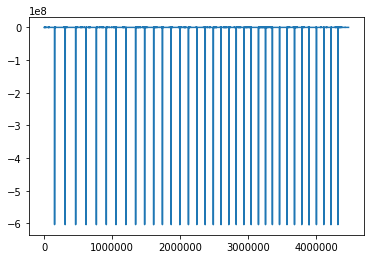

In [30]:
plt.plot([i for i in range(len(deltas))],deltas)

In [32]:
len(deltas)

4477224

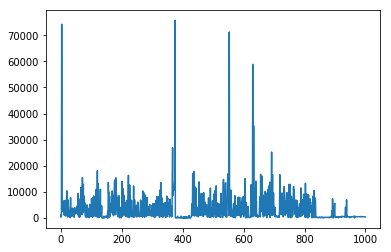

In [31]:
plt.plot([i for i in range(1000)],deltas[:1000])

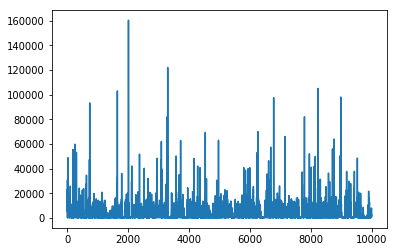

In [33]:
plt.plot([i for i in range(10000)],deltas[-10000:])

In [28]:
np.correlate(deltas[:-100],deltas[100:])

array([2116819616910], dtype=int64)